# Multi LLM Attention Experiment

This notebook pulls down the RoBERTa, LongFormer, and BigBird base models from HuggingFace, and evaluates the model's performance before and after finetuning with the GLUE and SuperGLUE datasets. Due to platform resource restrictions, LoRA adapters are used. The goal is to see how each model's attention mechanisms perform with these datesets.

The attention types are as follows:

| Model      | Attention Type      | Description                                                                                   |
|------------|---------------------|-----------------------------------------------------------------------------------------------|
| **RoBERTa**   | Full Attention       | Each token attends to every other token in the input. Quadratic complexity (`O(n²)`).           |
| **Longformer**| Sliding Window + Global | Sparse attention where each token attends to nearby neighbors (local window) and selected global tokens. Linear complexity (`O(n)`). |
| **BigBird**   | Random + Block + Global | Combines random attention, block local attention, and global tokens to ensure full coverage. Sub-quadratic complexity with theoretical guarantees (`O(n)`). |



## 1: Install Dependencies

In [ ]:
# Install necessary dependencies
# !pip install psutil GPUtil seaborn matplotlib fvcore evaluate torch prettytable peft bertviz

### Print out Environment Details

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('The runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('Using a high-RAM runtime!')

The runtime has 54.8 gigabytes of available RAM

Using a high-RAM runtime!


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar 29 20:50:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2: Import Dependencies and Setup Environment

In [74]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import glob
from prettytable import PrettyTable
from fvcore.nn import FlopCountAnalysis

from datasets import load_dataset
from peft import get_peft_model, LoraConfig, PeftModel, TaskType
from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModel,
    AutoModelForSequenceClassification,
    LongformerTokenizer,
    LongformerModel,
    PreTrainedModel,
    PretrainedConfig
)

In [5]:
# Set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {device}")


Using device: cuda


In [6]:
# Set storage path
from google.colab import drive
drive.mount('/content/drive')
local_storage_dir = "/content/drive/MyDrive/llm-tentive/multi_llm_attn_experiment"

Mounted at /content/drive


In [7]:
# Define model configs
model_configs = [
    {
        "label": "Full Attention (RoBERTa)",
        "model": "roberta-base",
        "model_path": "FacebookAI/roberta-base",
        "shortname": "roberta",
        "attention_type": "full",
        "is_roberta_base": True
    },
    {
        "label": "Adaptive Windowing (Longformer)",
        "model": "longformer-base-4096",
        "model_path": "allenai/longformer-base-4096",
        "shortname": "longformer",
        "attention_type": "sliding-window",
        "is_roberta_base": False  # the only model without RoBERTa base
    },
    {
        "label": "Sparse Attention (BigBird)",
        "model": "bigbird-roberta-base",
        "model_path": "google/bigbird-roberta-base",
        "shortname": "bigbird",
        "attention_type": "sparse",
        "is_roberta_base": True
    },
]

In [69]:
from transformers.utils import logging as hf_logging
import warnings
import logging

# turn this down to keep notebook clean
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
datasets.logging.set_verbosity_error()
logging.getLogger("fvcore").setLevel(logging.ERROR)

## 3: Visualize Attention, Embeddings, and Performance

### Define Attention Matrix Function

In [57]:
def clean_tokens(tokens, model_type):
    """Cleans up the odd tokens"""

    return [
        token.replace("Ġ", "").replace("▁", "").replace("##", "")
        for token in tokens
    ]


In [15]:
def calculate_flops(model, tokenizer, inputs, device):
    """Calculates FLOPs and returns in GFLOPs"""

    input_ids = inputs["input_ids"]

    with torch.no_grad():
        flops = FlopCountAnalysis(model, (input_ids,))

    return flops.total() / 1e9  # Return GFLOPs

In [16]:
def extract_structural_details(model, inputs):
    """Extract structural details from the model"""

    layers = len(model.encoder.layer)
    heads = model.config.num_attention_heads
    hidden = model.config.hidden_size
    sequence = inputs["input_ids"].shape[1]

    return layers, heads, hidden, sequence

### Loop Through All Models and Visualize Attention Mechanisms

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def visualize_model_aggregated_attention(
    model, tokenizer, text, device,
    model_short,
    max_tokens=50,
    global_token_positions=[0, 10, 20, 30],
    agg="mean"  # or "max"
):
    """
    Aggregates attention across all heads and layers into one matrix.
    Displays a single attention heatmap for the entire model.
    """
    model.eval()
    model.config.output_attentions = True

    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        max_length=512,
        truncation=True
    )

    # Assign global attention if model supports it
    if hasattr(model.config, "attention_window"):
        inputs["global_attention_mask"] = torch.zeros_like(inputs["input_ids"])
        for pos in global_token_positions:
            if pos < inputs["input_ids"].shape[1]:
                inputs["global_attention_mask"][:, pos] = 1

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get token IDs and filter out padding tokens
    token_ids = inputs["input_ids"][0]
    pad_token_id = tokenizer.pad_token_id
    valid_indices = (token_ids != pad_token_id).nonzero(as_tuple=True)[0]
    valid_indices = valid_indices[:max_tokens]  # Trim if too long

    tokens = tokenizer.convert_ids_to_tokens(token_ids[valid_indices])
    tokens = [t.replace("Ġ", "").replace("▁", "").replace("##", "") for t in tokens]

    # Aggregate attention across all layers and heads
    total_matrix = None
    for layer_attn in outputs.attentions:  # shape: (batch, heads, seq, seq)
        heads = layer_attn[0][:, valid_indices][:, :, valid_indices]  # (heads, seq', seq')
        if agg == "mean":
            layer_matrix = heads.mean(dim=0)
        elif agg == "max":
            layer_matrix = heads.max(dim=0)
        else:
            raise ValueError("Unsupported aggregation method")

        total_matrix = layer_matrix if total_matrix is None else total_matrix + layer_matrix

    total_matrix /= len(outputs.attentions)
    attn = total_matrix.cpu().numpy()

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="Blues", vmin=0, vmax=attn.max())
    plt.title(f"{model_short.upper()} Model-Wide Aggregated Attention (All Layers & Heads – {agg})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Loading model from FacebookAI/roberta-base


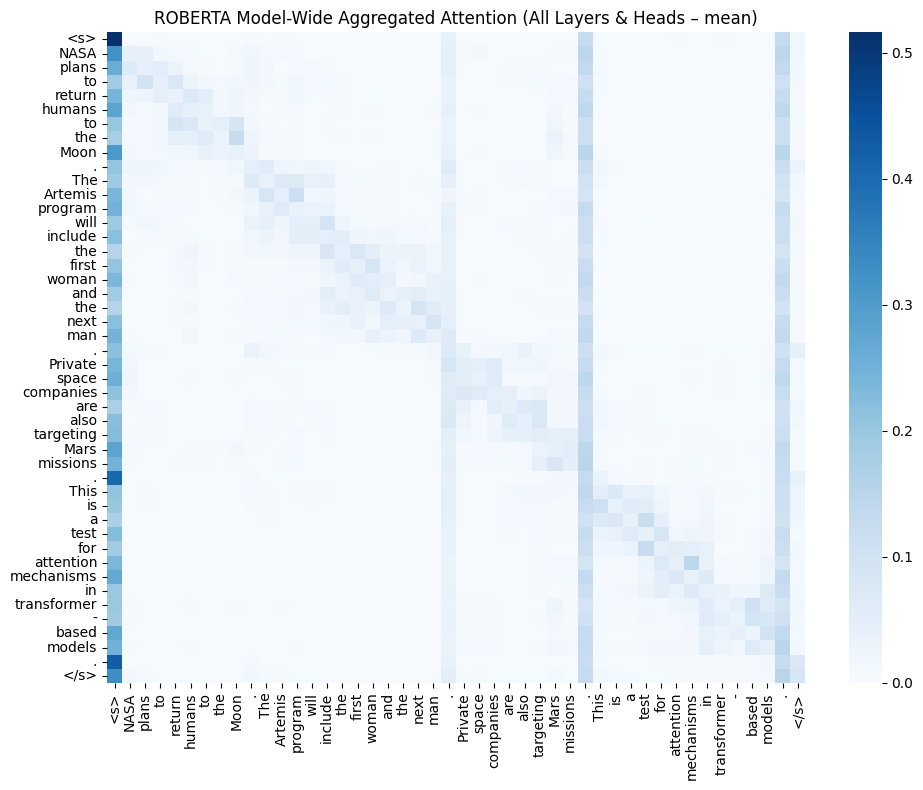

Loading model from allenai/longformer-base-4096


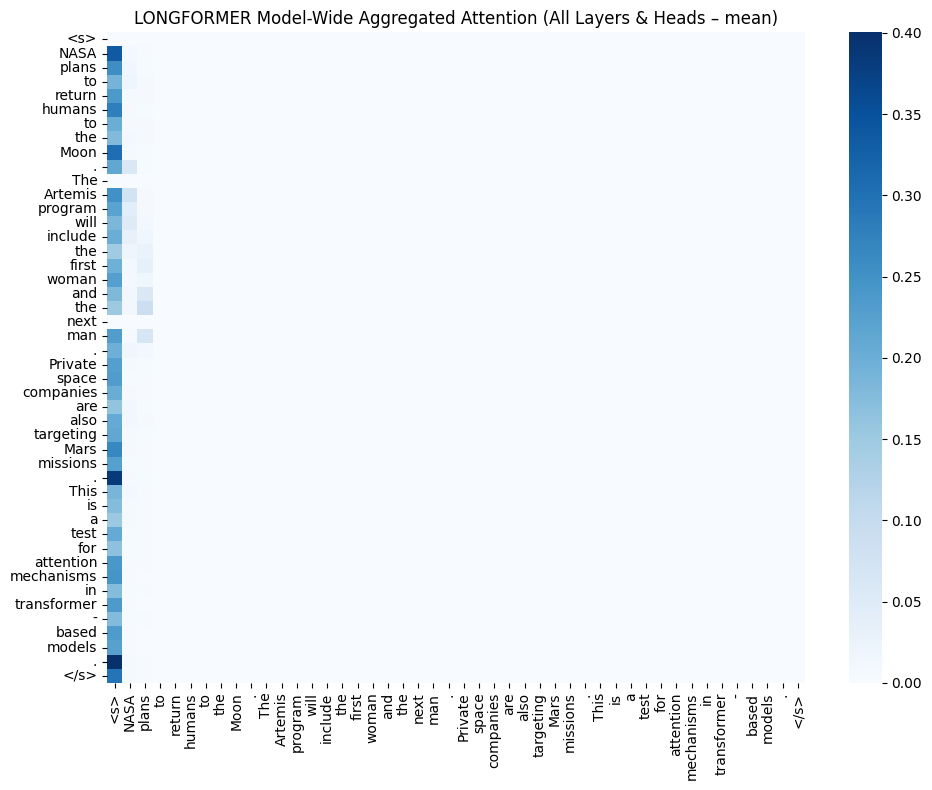

Loading model from google/bigbird-roberta-base


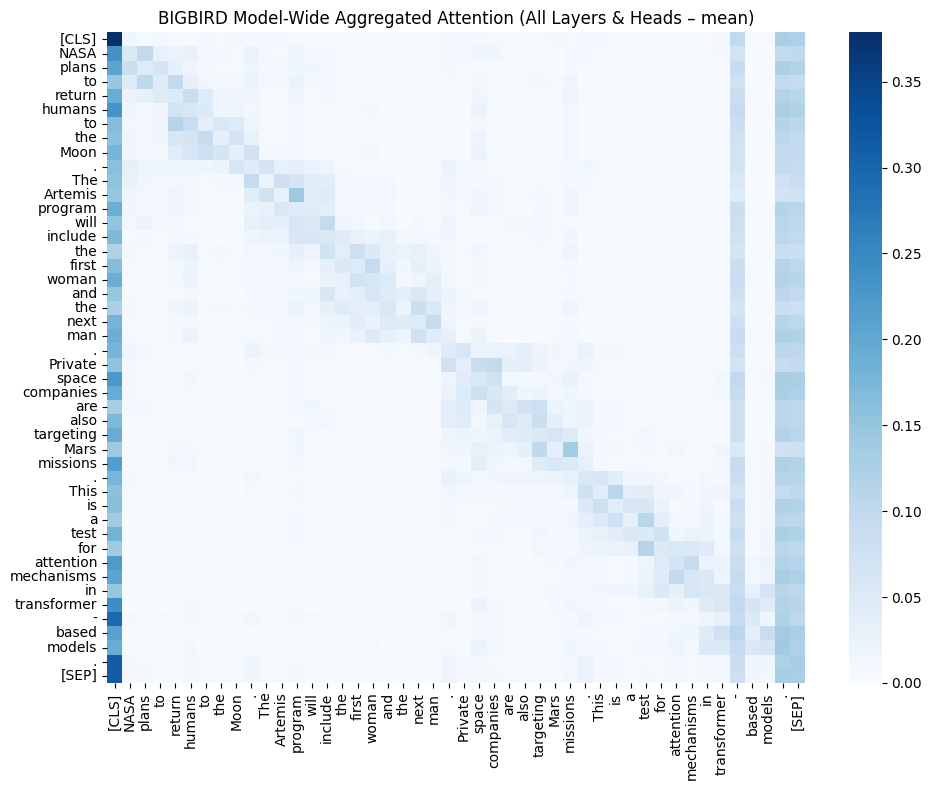

In [76]:
attention_matrices = []
tokens_list = []
model_labels = []
flops_list = []
structural_details = []

# Load the model and tokenizer from the local directory
for model_config in model_configs:
    model_path = model_config['model_path']

    # Clear cache every time
    torch.backends.mps.empty_cache() if torch.backends.mps.is_available() else torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"Loading model from {model_path}")

    # Load the model and tokenizer
    if model_config['shortname'].lower() == "longformer":
      tokenizer = LongformerTokenizer.from_pretrained(model_path)
      model = LongformerModel.from_pretrained(model_path)
    else:
      tokenizer = AutoTokenizer.from_pretrained(model_path)
      model = AutoModel.from_pretrained(model_path)

    model.to(device)
    model.eval()
    model.config.output_attentions = True

    # Define sample sentence
    text = (
        "NASA plans to return humans to the Moon. "
        "The Artemis program will include the first woman and the next man. "
        "Private space companies are also targeting Mars missions. "
        "This is a test for attention mechanisms in transformer-based models."
    )

    if model_config['shortname'].lower() == "longformer":
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            max_length=512,
            truncation=True
            )

        # Set global attention on the first token
        inputs["global_attention_mask"] = torch.zeros_like(inputs["input_ids"])
        inputs["global_attention_mask"][:, 0] = 1
        inputs = {k: v.to(device) for k, v in inputs.items()}
    else:
        inputs = tokenizer(text, return_tensors="pt").to(device)

    # Display attention visualizations
    global_tokens = [0, 10, 20] if "longformer" in model_path or "bigbird" in model_path else []
    visualize_model_aggregated_attention(
        model, tokenizer, text, device,
        model_config['shortname'],
        max_tokens=50,
        agg="mean",
        global_token_positions=global_tokens
    )

    # Add FLOPs Calculation
    flops_list.append(calculate_flops(model, tokenizer, inputs, device))

    # Extract structural details
    structural_details.append(extract_structural_details(model, inputs))

### Output FLOPs Calculations

In [66]:
# Create the table and output data for all three base models
table = PrettyTable()
table.field_names = ["Attention/Model", "Layers", "Heads", "Hidden", "Sequence", "FLOPs (GFLOPs)"]

# Populate the table with data
for model_label, structural_specs, flops_calc in zip(model_labels, structural_details, flops_list):
    layers, heads, hidden, sequence = structural_specs
    g_flops = f"~{flops_calc:.2f}G"
    table.add_row([model_label, layers, heads, hidden, sequence, g_flops])

# Print the table
print(table)


+---------------------------------+--------+-------+--------+----------+----------------+
|         Attention/Model         | Layers | Heads | Hidden | Sequence | FLOPs (GFLOPs) |
+---------------------------------+--------+-------+--------+----------+----------------+
|     Full Attention (RoBERTa)    |   12   |   12  |  768   |    46    |     ~3.95G     |
| Adaptive Windowing (Longformer) |   12   |   12  |  768   |   512    |    ~49.58G     |
|    Sparse Attention (BigBird)   |   12   |   12  |  768   |    46    |     ~3.95G     |
+---------------------------------+--------+-------+--------+----------+----------------+


When running on MPS, the complexity will be presented the same as CUDA, but the memory requirements will be different. The model will require more memory to run on MPS than it would on CUDA.

Longformer, despite being passed in a sequence of 12, will allocate memory for the full 4096 sequence max. For smaller sequences, RoBERTa will be the cheapest. Furthermore, BigBird will revert to default RoBERTa functionality when sequence below ~700 is provided. For other attention mechanisms, pass in a greater token sequence.

## Step 5: Perform Pre-Train Benchmarking

In [11]:
# The time has come, empty cache
import gc
def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print("GPU memory cleared.")

clear_cuda() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.backends.mps.is_available() else None

GPU memory cleared.


In [12]:
# Set verbosity to info in order to show logs and trainer
hf_logging.set_verbosity_warning()

In [13]:
# Tokenize function
def tokenize_function(example, tokenizer, max_length=512):
    # Try dual sentence fields
    if "sentence1" in example and "sentence2" in example:
        return tokenizer(
            example["sentence1"],
            example["sentence2"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    # Try single sentence field
    elif "sentence" in example:
        return tokenizer(
            example["sentence"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    # If other formats like premise/hypothesis exist
    elif "premise" in example and "hypothesis" in example:
        return tokenizer(
            example["premise"],
            example["hypothesis"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    # If unknown format
    else:
        raise ValueError("Unsupported input format in example: {}".format(example.keys()))


def compute_metrics(eval_pred):
    """Compute accuracy for tasks."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy_metric = evaluate.load("accuracy")

    return accuracy_metric.compute(predictions=predictions, references=labels)


def train_and_evaluate(model_name: str, model, dataset, data_collator, output_dir, epochs: int = 3):
    """Trains models on for quick comparison."""

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy= "no", # if you want the models at the end, set to 'epoch'
        num_train_epochs=epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=2e-5,
        weight_decay=0.01,
        fp16=True,
        load_best_model_at_end=False, # if you want the models at the end, set to 'True'
        metric_for_best_model="eval_accuracy",
        push_to_hub=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,  # Handles MLM masking
        compute_metrics=compute_metrics  # Evaluates accuracy on GLUE task
    )

    # Evaluate before training
    pretrain_results = trainer.evaluate()
    print("Pretrained Model Eval:", pretrain_results)

    # Empty cache and begin training
    print("Starting training with memory/speed benchmarks")
    torch.mps.empty_cache() if torch.backends.mps.is_available() else torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Time the training process
    start_time = time.time()
    trainer.train()
    end_time = time.time()

    # Memory usage
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated() / 1024**3  # Convert to GB
        memory_reserved = torch.cuda.memory_reserved() / 1024**3  # Convert to GB
    elif torch.backends.mps.is_available():
        memory_allocated = torch.mps.memory_allocated() / 1024**3  # Convert to GB
        memory_reserved = torch.mps.memory_reserved() / 1024**3  # Convert to GB

    print(f"Training Time: {end_time - start_time:.2f} seconds")
    print(f"GPU Memory Allocated: {memory_allocated:.2f} GB")
    print(f"GPU Memory Reserved: {memory_reserved:.2f} GB")

    posttrain_results = trainer.evaluate()
    print("GLUE Post-Fine-Tuning Eval:", posttrain_results)

    sentence = "This is a model benchmarking test for inference speed."
    inputs = tokenizer(sentence, return_tensors="pt").to(model.device)
    inputs.pop("labels", None)  # Just in case

    start_inf = time.time()

    with torch.no_grad():
        _ = model(**inputs)

    end_inf = time.time()

    print(f"Inference Time (Single Sentence): {end_inf - start_inf:.6f} sec")

    result_dict = {
        "model": model_name,
        "pretrain_eval": pretrain_results,
        "posttrain_eval": posttrain_results,
        "training_time_sec": round(end_time - start_time, 2),
        "gpu_memory_allocated_gb": round(memory_allocated, 2),
        "gpu_memory_reserved_gb": round(memory_reserved, 2),
        "inference_time_sec": round(end_inf - start_inf, 6)
    }

    return result_dict


In [14]:
# Apply LoRA
def apply_lora(model, target_modules, device, print_trainable_params=True):
    """Applies LoRA"""

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        target_modules=target_modules,
        task_type=TaskType.SEQ_CLS,
    )

    # Apply LoRA to model
    model = get_peft_model(model, lora_config)
    model.to(device)

    if print_trainable_params:

        model.print_trainable_parameters()

    return model

### Train and Eval Each Model on Multiple Glue Tasks

Tasks included in this notebook:

| Task   | Full Name                                | Description                                                                 |
|--------|-------------------------------------------|-----------------------------------------------------------------------------|
| **mrpc**  | Microsoft Research Paraphrase Corpus     | Binary classification: are two sentences paraphrases of each other?        |
| **sst2**  | Stanford Sentiment Treebank (version 2)  | Binary sentiment classification of a single sentence (positive/negative)   |
| **cola**  | Corpus of Linguistic Acceptability       | Binary classification: is a sentence linguistically acceptable (grammatical)? |
| **qnli**  | Question Natural Language Inference      | Binary classification: does a context sentence answer a given question? (entailment vs not) |


In [15]:
save_dir = f"{local_storage_dir}/benchmarking"
os.makedirs(save_dir, exist_ok=True)

def get_result_path(model_short, task_name):
    """Checks to ensure CSV file for model/task pairing exists"""
    return os.path.join(save_dir, f"{model_short}_{task_name}_result.csv")

def save_single_result(result_dict, save_path):
    """Saves CSV of results for single model"""
    df = pd.DataFrame([result_dict])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_csv(save_path, index=False)

In [17]:
EPOCHS = 3

# Set desired Glue Tasks
glue_tasks = ["mrpc", "sst2", "cola", "qnli"]

benchmark_results = []

# Run training and evaluation for each model
for model_config in model_configs:

    # For every model, loop through the glue tasks
    for task in glue_tasks:
        # The session times out after a few models/tasks (some hosted NBs)
        # check to make sure the current pairing doesn't already
        # exist, continue to the next one if so

        result_path = get_result_path(model_config['shortname'], task)

        if os.path.exists(result_path):
            print(f"{model_config['shortname']} on {task} — result exists.")
            print("Skipping...\n")

            continue

        glue_dataset = load_dataset("glue", task)
        num_labels = glue_dataset["train"].features["label"].num_classes

        model_name = model_config["model_path"]

        # Load Model and Tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Apply LoRA
        model = apply_lora(
                model=model,
                target_modules=["query", "key", "value", "dense"], # Longformer and RoBERTa target modules
                device=device,
                print_trainable_params=True
            )

        # Tokenize datasets
        tokenized_datasets = glue_dataset.map(
                lambda example: tokenize_function(example, tokenizer),
                batched=True,
            )
        tokenized_datasets = tokenized_datasets.remove_columns(
            [col for col in tokenized_datasets.column_names["train"]
             if col not in {"input_ids", "attention_mask", "label"}]
        )

        data_collator = DataCollatorWithPadding(
            tokenizer=tokenizer,
        )

        model_performance = train_and_evaluate(
            model_name=model_name,
            model=model,
            dataset=tokenized_datasets,
            data_collator=data_collator,
            output_dir=f"{local_storage_dir}/{model_name.lower()}-glue",
            epochs=EPOCHS
        )

        model_performance.update({"dataset": "GLUE"})
        model_performance.update({"task": task})

        # Print results
        print(model_performance)

        # Append results to the list
        benchmark_results.append(model_performance)

        # Save on a per model/task basis due to system session timeout
        save_path = f"{save_dir}/{model_config['shortname']}_{task}_result.csv"
        save_single_result(model_performance, save_path)

roberta on mrpc — result exists.
Skipping...

roberta on sst2 — result exists.
Skipping...

roberta on cola — result exists.
Skipping...

roberta on qnli — result exists.
Skipping...

longformer on mrpc — result exists.
Skipping...

longformer on sst2 — result exists.
Skipping...

longformer on cola — result exists.
Skipping...

longformer on qnli — result exists.
Skipping...

bigbird on mrpc — result exists.
Skipping...

bigbird on sst2 — result exists.
Skipping...

bigbird on cola — result exists.
Skipping...



train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

trainable params: 1,931,522 || all params: 130,004,740 || trainable%: 1.4857


Map:   0%|          | 0/104743 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

<ipython-input-13-a64493d9d613>:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Pretrained Model Eval: {'eval_loss': 0.6979117393493652, 'eval_model_preparation_time': 0.0088, 'eval_accuracy': 0.5053999633900788, 'eval_runtime': 113.442, 'eval_samples_per_second': 48.157, 'eval_steps_per_second': 6.021}
Starting training with memory/speed benchmarks


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.658000,0.648779,0.008800,0.615596
2,0.648100,0.648008,0.008800,0.617060


Training Time: 18093.13 seconds
GPU Memory Allocated: 0.52 GB
GPU Memory Reserved: 6.41 GB


GLUE Post-Fine-Tuning Eval: {'eval_loss': 0.648007869720459, 'eval_model_preparation_time': 0.0088, 'eval_accuracy': 0.6170602233205199, 'eval_runtime': 123.7898, 'eval_samples_per_second': 44.131, 'eval_steps_per_second': 5.517, 'epoch': 2.9996181165508284}
Inference Time (Single Sentence): 0.047828 sec
{'model': 'google/bigbird-roberta-base', 'pretrain_eval': {'eval_loss': 0.6979117393493652, 'eval_model_preparation_time': 0.0088, 'eval_accuracy': 0.5053999633900788, 'eval_runtime': 113.442, 'eval_samples_per_second': 48.157, 'eval_steps_per_second': 6.021}, 'posttrain_eval': {'eval_loss': 0.648007869720459, 'eval_model_preparation_time': 0.0088, 'eval_accuracy': 0.6170602233205199, 'eval_runtime': 123.7898, 'eval_samples_per_second': 44.131, 'eval_steps_per_second': 5.517, 'epoch': 2.9996181165508284}, 'training_time_sec': 18093.13, 'gpu_memory_allocated_gb': 0.52, 'gpu_memory_reserved_gb': 6.41, 'inference_time_sec': 0.047828, 'dataset': 'GLUE', 'task': 'qnli'}


### Output GLUE Benchmark Results

In [31]:
def consolidate_results(results_dir):
    """Iterates through all results and consolidates into singular CSV"""
    files = glob.glob(os.path.join(results_dir, f"{save_dir}/*_result.csv"))
    dfs = [pd.read_csv(file) for file in files]
    consolidated = pd.concat(dfs, ignore_index=True)
    consolidated.to_csv(os.path.join(results_dir, f"{save_dir}/glue_benchmark_summary.csv"), index=False)

    return consolidated

glue_results_df = consolidate_results(f"{save_dir}/")
glue_results_df.head()

,model,pretrain_eval,posttrain_eval,training_time_sec,gpu_memory_allocated_gb,gpu_memory_reserved_gb,inference_time_sec,dataset,task
0,FacebookAI/roberta-base,"{'eval_loss': 0.6934646368026733, 'eval_model_...","{'eval_loss': 0.20472459495067596, 'eval_model...",6366.78,0.51,2.80,0.029123,GLUE,sst2
1,FacebookAI/roberta-base,"{'eval_loss': 0.6891067028045654, 'eval_model_...","{'eval_loss': 0.5161628723144531, 'eval_model_...",841.13,0.51,2.78,0.028188,GLUE,cola
2,FacebookAI/roberta-base,"{'eval_loss': 0.7132185101509094, 'eval_model_...","{'eval_loss': 0.5480102896690369, 'eval_model_...",365.70,0.50,2.81,0.045437,GLUE,mrpc
3,FacebookAI/roberta-base,"{'eval_loss': 0.694190263748169, 'eval_model_p...","{'eval_loss': 0.643629252910614, 'eval_model_p...",10305.41,1.02,3.32,0.030522,GLUE,qnli
4,allenai/longformer-base-4096,"{'eval_loss': 0.6916683316230774, 'eval_model_...","{'eval_loss': 0.5992162227630615, 'eval_model_...",1485.65,1.10,6.15,0.086705,GLUE,mrpc


In [69]:
glue_results_df.describe()

,training_time_sec,gpu_memory_allocated_gb,gpu_memory_reserved_gb,inference_time_sec,accuracy,loss_delta,memory_utilization,pretrain_accuracy,posttrain_accuracy,pretrain_loss,posttrain_loss,loss_reduction,accuracy_gain,gpu_utilization_ratio,loss
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,10294.218333,0.709167,5.143333,0.051860,0.752691,0.206946,0.151113,0.511586,0.752691,0.697873,0.490927,0.206946,0.241105,0.151113,0.490927
std,12933.603158,0.275564,1.660172,0.024893,0.122654,0.172232,0.068575,0.113330,0.122654,0.011593,0.173892,0.172232,0.158530,0.068575,0.173892
min,365.700000,0.500000,2.780000,0.028188,0.617060,0.049904,0.079755,0.308725,0.617060,0.689107,0.204725,0.049904,0.090686,0.079755,0.204725
25%,1324.520000,0.517500,3.192500,0.032671,0.670748,0.082375,0.080812,0.491686,0.670748,0.691344,0.440333,0.082375,0.112474,0.080812,0.440333
50%,4927.065000,0.520000,6.140000,0.040462,0.706354,0.160134,0.178399,0.505400,0.706354,0.693868,0.557552,0.160134,0.131613,0.178399,0.557552
75%,13266.272500,1.040000,6.435000,0.081771,0.826326,0.250831,0.180120,0.583946,0.826326,0.696604,0.610319,0.250831,0.414704,0.180120,0.610319
max,42176.890000,1.100000,6.520000,0.087401,0.938073,0.488740,0.307229,0.682646,0.938073,0.728733,0.648008,0.488740,0.446101,0.307229,0.648008


In [32]:
import ast

# Parse the dictionary strings into actual dictionaries
glue_results_df["pretrain_eval"] = glue_results_df[
        "pretrain_eval"
    ].apply(ast.literal_eval)
glue_results_df["posttrain_eval"] = glue_results_df[
        "posttrain_eval"
    ].apply(ast.literal_eval)

glue_results_df["accuracy"] = glue_results_df[
        "posttrain_eval"
    ].apply(lambda x: x["eval_accuracy"])


# Extract key metrics
glue_results_df["loss_delta"] = glue_results_df["pretrain_eval"].apply(
    lambda x: x["eval_loss"]
    ) - glue_results_df["posttrain_eval"].apply(lambda x: x["eval_loss"])

glue_results_df["memory_utilization"] = glue_results_df["gpu_memory_allocated_gb"] / glue_results_df["gpu_memory_reserved_gb"]

glue_results_df["pretrain_accuracy"] = glue_results_df[
    "pretrain_eval"
].apply(lambda x: x["eval_accuracy"])

glue_results_df["posttrain_accuracy"] = glue_results_df[
        "posttrain_eval"
    ].apply(lambda x: x["eval_accuracy"])
glue_results_df["pretrain_loss"] = glue_results_df[
        "pretrain_eval"
    ].apply(lambda x: x["eval_loss"])
glue_results_df["posttrain_loss"] = glue_results_df[
        "posttrain_eval"
    ].apply(lambda x: x["eval_loss"])
glue_results_df["loss_reduction"] = glue_results_df["pretrain_loss"] - glue_results_df["posttrain_loss"]
glue_results_df["accuracy_gain"] = glue_results_df["posttrain_accuracy"] - glue_results_df["pretrain_accuracy"]
glue_results_df["gpu_utilization_ratio"] = glue_results_df["gpu_memory_allocated_gb"] / glue_results_df["gpu_memory_reserved_gb"]
glue_results_df["model_short"] = glue_results_df["model"].apply(lambda x: x.split("/")[1].split("-")[0])
glue_results_df["loss"] = glue_results_df["posttrain_eval"].apply(lambda x: x["eval_loss"])


In [63]:
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt

# Reported baselines
baseline_scores = {
    "sst2": 0.948,
    "mrpc": 0.889,
    "cola": 0.636,
    "qnli": 0.928,
    "rte": 0.719,
    "mnli": 0.876
}

def plot_accuracy_heatmap(df, value_col="accuracy"):
    """
    df should have columns: model_short, task, accuracy
    """
    heatmap_data = df.pivot(index="model_short", columns="task", values=value_col)
    plt.figure(figsize=(8, 5))

    # Desaturate the "Set2" palette:
    colors = sns.color_palette("Set2", n_colors=heatmap_data.shape[0])
    desaturated_colors = [sns.desaturate(color, 0.7) for color in colors] # Adjust 0.7 for desired level


    sns.heatmap(heatmap_data, annot=True, cmap=sns.color_palette(desaturated_colors), fmt=".2f")
    plt.title("Model Accuracy Heatmap Across GLUE Tasks")
    plt.xlabel("GLUE Task")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

def plot_accuracy_facet_grid(df, model_col="model_short", task_col="task", value_col="accuracy", baseline_scores=None):
    """
    df should have columns: model_short, task, accuracy
    baseline_scores should be a dict: {task_name: baseline_value}
    """
    tasks_ordered = sorted(df[task_col].unique())
    palette = sns.color_palette("Set2", len(tasks_ordered))
    palette_dict = dict(zip(tasks_ordered, palette))

    g = sns.FacetGrid(df, col=model_col, sharey=True, col_wrap=3, height=4)

    # draw barplot
    g.map_dataframe(
        sns.barplot,
        x=task_col,
        y=value_col,
        palette=palette_dict,
        order=tasks_ordered,
        hue=task_col,
        legend=False
    )

    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("GLUE Task", "Accuracy")

    # draw baselines
    if baseline_scores:
        for ax in g.axes.flatten():
            xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
            for task in xtick_labels:
                if task in baseline_scores:
                    color = palette_dict.get(task, "gray")
                    ax.axhline(y=baseline_scores[task], linestyle='--', color=color, alpha=0.8)

    # rotate task names
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


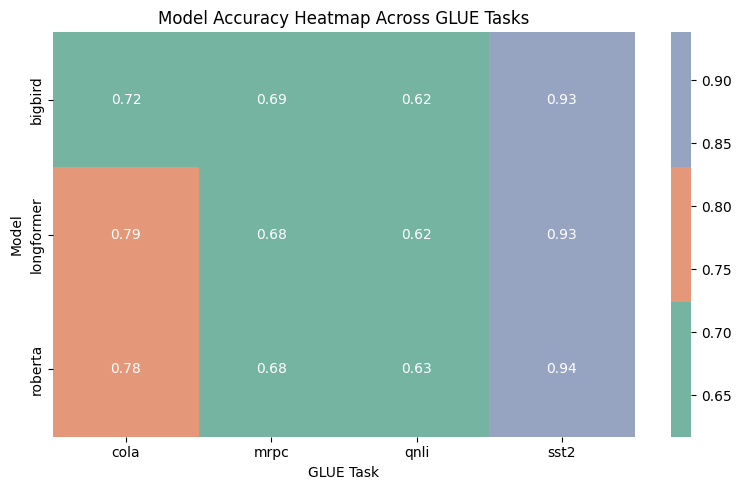

In [67]:
plot_accuracy_heatmap(glue_results_df)

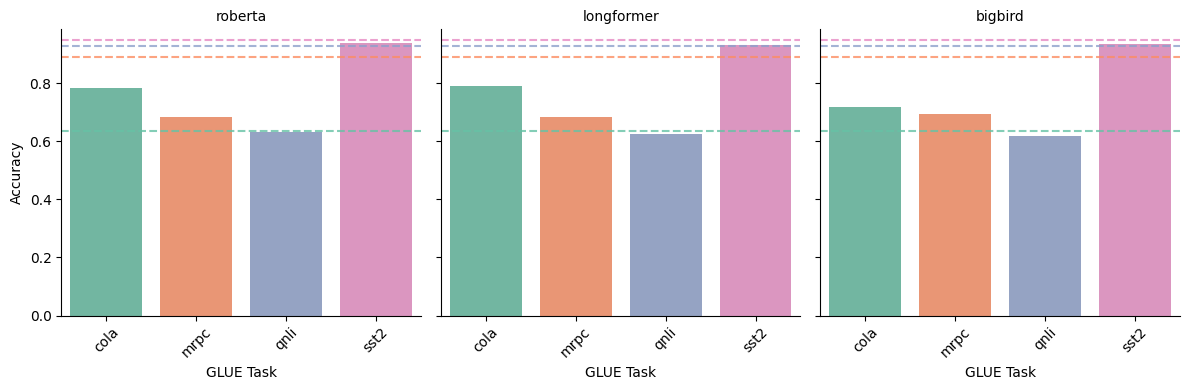

In [68]:
# Plot the accuracy per task for every model and display reported baseline accuracies of these models
plot_accuracy_facet_grid(glue_results_df, baseline_scores=baseline_scores)

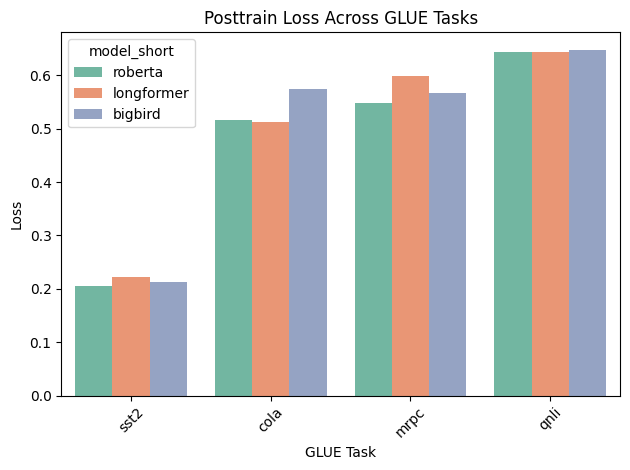

In [47]:
sns.barplot(data=glue_results_df, x="task", y="loss", hue="model_short", palette="Set2")
plt.title("Posttrain Loss Across GLUE Tasks")
plt.xlabel("GLUE Task")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


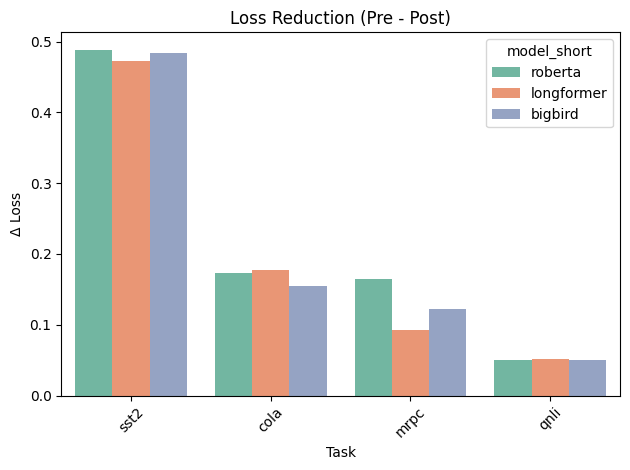

In [46]:

sns.barplot(data=glue_results_df, x="task", y="loss_delta", hue="model_short", palette="Set2")
plt.title("Loss Reduction (Pre - Post)")
plt.xlabel("Task")
plt.ylabel("Δ Loss")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


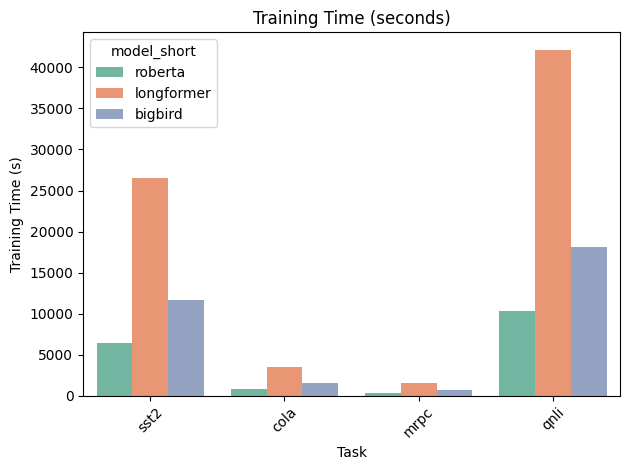

In [45]:
sns.barplot(data=glue_results_df, x="task", y="training_time_sec", hue="model_short", palette="Set2")
plt.title("Training Time (seconds)")
plt.xlabel("Task")
plt.ylabel("Training Time (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Longformer maintained the highest training time of all the models across all taks, followed by BigBird and then RoBERTa.

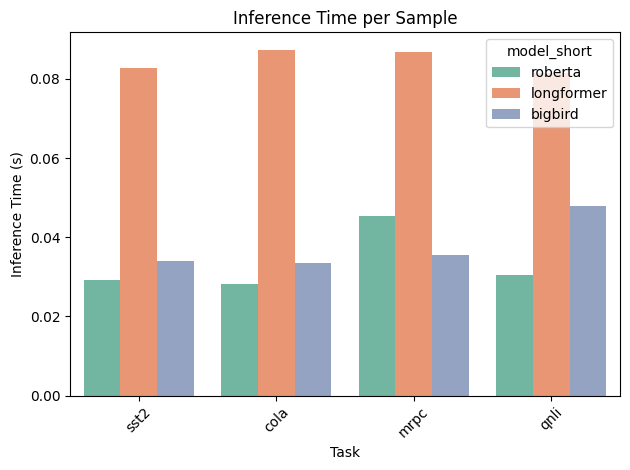

In [44]:
sns.barplot(data=glue_results_df, x="task", y="inference_time_sec", hue="model_short", palette="Set2")
plt.title("Inference Time per Sample")
plt.xlabel("Task")
plt.ylabel("Inference Time (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Longformer had the highest inference time across all tasks. BigBird had the second highest inference times with the SST2, Cola, and QNLI tasks and RoBERTa had the second highest inference time on MRPC.

Text(0.5, 0.98, 'GPU Memory Usage (Allocated vs Reserved) per Task and Model')

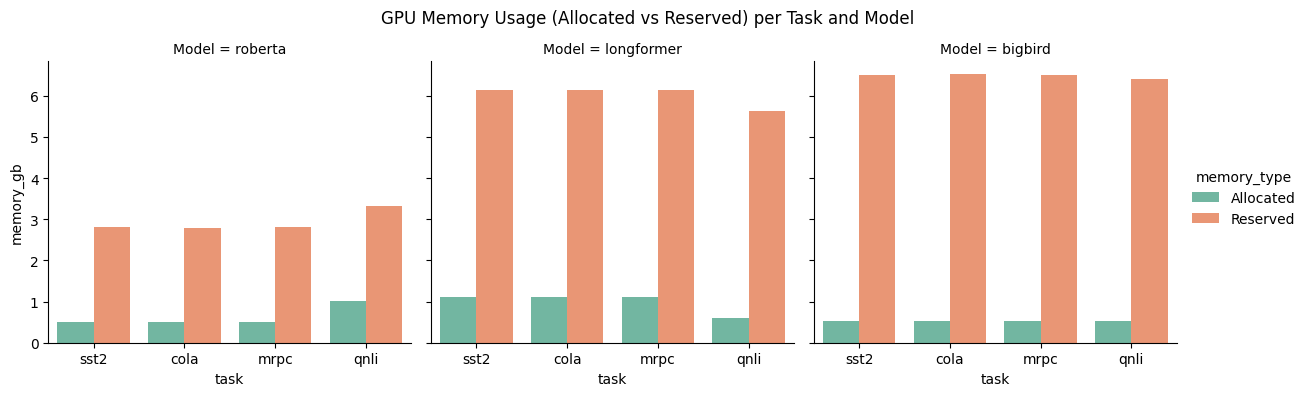

In [39]:
# melt to long-form
df_melted = glue_results_df.melt(
    id_vars=["task", "model_short"],
    value_vars=["gpu_memory_allocated_gb", "gpu_memory_reserved_gb"],
    var_name="memory_type",
    value_name="memory_gb"
)

# Shorten labels
df_melted["memory_type"] = df_melted["memory_type"].replace({
    "gpu_memory_allocated_gb": "Allocated",
    "gpu_memory_reserved_gb": "Reserved",
})

df_melted = df_melted.rename(columns={"model_short": "Model"})

sns.catplot(
    data=df_melted,
    kind="bar",
    x="task",
    y="memory_gb",
    hue="memory_type",
    col="Model",  # one column per model
    palette="Set2",
    height=4,
    aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle("GPU Memory Usage (Allocated vs Reserved) per Task and Model")



RoBERTa has the smallest footprint of the three since it has the smallest context window. Longformer has a context window of 4096 tokens. So with the sliding window attention and buffers, it will take more space. BigBird has the added feature of sparse attention, so it's space requirements are slightly more than Longformer.

Text(0, 0.5, 'Memory Utilization')

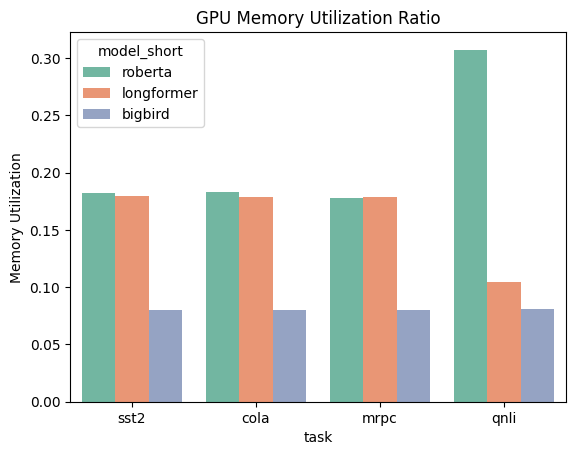

In [40]:
sns.barplot(data=glue_results_df, x="task", y="memory_utilization", hue="model_short", palette="Set2")
plt.title("GPU Memory Utilization Ratio")
plt.ylabel("Memory Utilization")



Text(0, 0.5, 'Accuracy Gain')

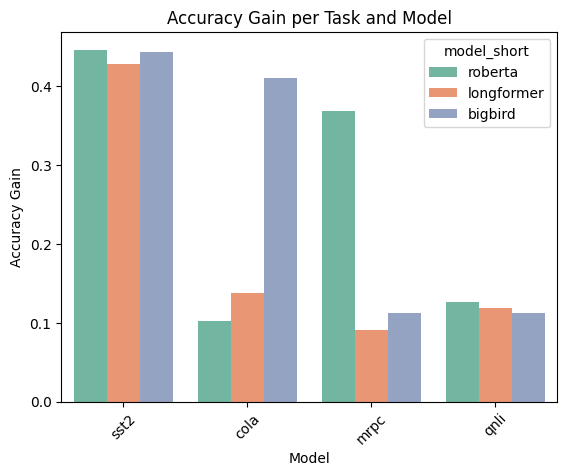

In [41]:
sns.barplot(data=glue_results_df, x="task", y="accuracy_gain", hue="model_short", palette="Set2")
plt.title("Accuracy Gain per Task and Model")
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Accuracy Gain")


Per the chart above, the greatest accuracy gain was seen in RoBERTa and BigBird. As shown in other experiments, LongFormer and BigBird will do better with longer contexts.

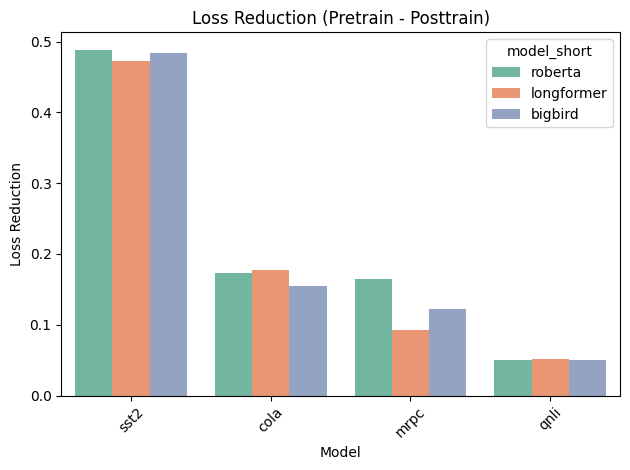

In [42]:
sns.barplot(data=glue_results_df, x="task", y="loss_reduction", hue="model_short", palette="Set2")
plt.title("Loss Reduction (Pretrain - Posttrain)")
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Loss Reduction")
plt.tight_layout()
plt.show()


RoBERTa maintained the greatest loss reduction in the SST2 and MRPC tasks, where as Longformer held the greatest loss reduction for COLA and QNLI tasks. The three models were close in the QNLI tasks. With smaller context windows, RoBERTa will do well, whereas Longformer and BigBird will do better with longer context. A key trade-off with Longformer and BigBird is that they trade off some token-level performance for scalability. The smaller the window, these trade offs will become noticeable such as above in the loss reduction and accuracy.